In [1]:

# Preliminaries ----

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

#' Set up a dictionary so we can label teams by conference later
conference = {
    'Eastern': {
        'FC Cincinnati', 'New England', 'Orlando City', 'Philadelphia', 'Columbus Crew',
        'Atlanta Utd', 'Nashville', 'CF Montréal', 'D.C. United', 'Chicago Fire', 'Charlotte',
        'NYCFC', 'NY Red Bulls', 'Inter Miami', 'Toronto FC'
    },
    'Western': {
        'St. Louis', 'Seattle', 'Los Angeles FC', 'Real Salt Lake', 'Dynamo FC', 'Vancouver',
        'Minnesota Utd', 'San Jose', 'FC Dallas', 'Austin', 'Sporting KC', 'Portland Timbers',
        'LA Galaxy', 'Colorado Rapids'
    }
}


In [ ]:
'''
## EXERCISE 1 ##
In this block of code, we wrangle the data and fit a least-squares (i.e. OLS) Bradley-Terry model.
However, we add a new wrinkle, and we include a variable indicating whether Lionel Messi is on the
pitch. Your task is to fill in the missing variable that tracks games in which Messi played.
'''

# Read data from file
matches = (
    pd.read_csv('mls_2023_supplemented.csv')
        .assign(
            xg_diff=lambda x: x['xg_home'] - x['xg_away'],
            goals_home=lambda x: x['score'].str[0],
            goals_away=lambda x: x['score'].str[2],
            past=lambda x: np.logical_not(np.isnan(x['xg_diff'])),  # games that have been played
            future=lambda x: np.isnan(x['xg_diff'])     # games that haven't been played yet
        )
)


# Set up the data to fit the Bradley-Terry model ----

# Create a dataframe of home xG scores
data_home = (
    matches.copy()
        .assign(
            is_home=1,
            offense=lambda x: x['home'],
            defense=lambda x: x['away'],
            xg=lambda x: x['xg_home']
        )
)

# Create a dataframe of away xG scores
data_away = (
    matches.copy()
        .assign(
            is_home=0,
            offense=lambda x: x['away'],
            defense=lambda x: x['home'],
            xg=lambda x: x['xg_away']
        )
)

# Put the home and away dataframes together
# TODO: Add two columns to this dataframe: `messi_off` and `messi_def`. The former is 1 if Messi
#       is playing for the offense in the match and 0 otherwise. Similarly, the latter is 1 if
#       Messi is playing for the defence in the match and 0 otherwise.
# HINT: The dataframe already has a helpful column `messi` indicating whether Messi played in the
#       game. Use the fact that Messi only plays for Inter Miami to calculate the column you need.
data = pd.concat([data_home, data_away])


# Fit the Bradley-Terry model ----

model = (
    smf.ols(
        formula="xg ~ is_home + offense + messi_off + defense + messi_def",
        data=data.loc[lambda x: x['past']]
    ).fit()
)

model.summary()


In [ ]:
'''
## EXERCISE 2 ##
In this block of code, we interpret the results of the model estimated in the previous block.
Specifically, we want to know where Inter Miami ranked among MLS teams before the acquisition of
Messi, and where they rank now following the acquisition. You don't have to write any code in this
section, but your task is to review the output below (and above) to answer the following questions:
Where does Inter Miami rank among MLS teams wihout Messi? How about with Messi?
'''

# Extract estimated offense coefficients
team_offense = (
    model.params
        .reset_index()
        .loc[lambda x: x['index'].str[0:7] == 'offense']
        .assign(
            team = lambda x: x['index'].str[10:-1],
            offense = lambda x: x[0]
        )
        .filter(['team', 'offense'])
)

# Extract estimated defense coefficients
team_defense = (
    model.params
        .reset_index()
        .loc[lambda x: x['index'].str[0:7] == 'defense']
        .assign(
            team = lambda x: x['index'].str[10:-1],
            defense = lambda x: x[0]
        )
        .filter(['team', 'defense'])
)

# Subtract defense coefficent from offense coefficient to get overall team rating
team_overall = (
    pd.merge(team_offense, team_defense)
        .assign(overall=lambda x: x['offense'] - x['defense'])
)

team_overall.sort_values('overall', ascending = False)


In [ ]:
'''
## EXERCISE 3 ##
In this block of code, we're calculating the MLS table (i.e. standings) as is currently stands.
Your job is to fill in the match-by-match points calculation for the home and away team so that
when the points get aggregated, they accurately reflect the current table.
'''

# Calculate the number of points earned in each match already completed
points_past_by_match = (
   matches
        .loc[lambda x: x['past'] & (x['competition'] == 'MLS')]
        .assign(
            goals_home=lambda x: x['goals_home'].astype(int),
            goals_away=lambda x: x['goals_away'].astype(int),
            # TODO: Calculate points_home and points_away
            # HINT: Try the select function from numpy
            points_home=0,
            points_away=0
        )
)

# Aggregate points accumulated at home by each team
points_home_past = (
    points_past_by_match
        .groupby(['home'])
        .agg({'points_home': 'sum'})
)

# Aggregate points accumulated away by each team
points_away_past = (
    points_past_by_match
        .groupby(['away'])
        .agg({'points_away': 'sum'})
)

# Add home and away point totals together
points_past = (
    pd.concat([points_home_past, points_away_past], axis=1)
        .assign(points_past=lambda x: x['points_home'] + x['points_away'])
        .filter(['points_past'])
)

# Check that this matches https://fbref.com/en/comps/22/Major-League-Soccer-Stats
points_past.sort_values(by='points_past', ascending=False)


In [5]:
'''
## EXERCISE 4 ##
In this block of code, we're simulating all remaining MLS regular season matches.
Your task is to use these simulated results to calculate Inter Miami's final
ranking in the Eastern Conference table at the end of the simulated season.
If Inter Miami finish among the top 9, they make the playoffs!
'''

data_future = data.loc[lambda x: x['future']]
matches_future = matches.loc[lambda x: x['future']]


# Simulate future results ----

# Simulate the number of goals scored by each team
sim_goals = np.random.poisson(model.predict(exog=data_future))
sim_goals_home = sim_goals[data_future['is_home'] == 1]
sim_goals_away = sim_goals[data_future['is_home'] == 0]

# Calcuate points for home team based on match result
sim_points_home = np.select(
    condlist=[
        sim_goals_home > sim_goals_away,
        sim_goals_home == sim_goals_away,
        sim_goals_home < sim_goals_away
    ],
    choicelist=[3, 1, 0]
)

# Calcuate points for away team based on match result
sim_points_away = np.select(
    condlist=[sim_points_home == 0, sim_points_home == 1, sim_points_home == 3],
    choicelist=[3, 1, 0]
)


# Aggregate points to calculate standings ----

# Create a pandas dataframe with home, away, home_points and away_points
points_future_by_match = (
    matches_future
        .loc[lambda x: x['future']]
        .assign(points_home=sim_points_home, points_away=sim_points_away)
)

# Aggregate points at home for each team
points_home_future = (
    points_future_by_match
        .groupby(['home'])
        .agg({'points_home': 'sum'})
)

# Aggregate points away for each team
points_away_future = (
    points_future_by_match
        .groupby(['away'])
        .agg({'points_away': 'sum'})
)

# Put home points and away points together
points_future = (
    pd.concat([points_home_future, points_away_future], axis=1)
        .assign(points_future=lambda x: x['points_home'] + x['points_away'])
        .filter(['points_future'])
)

# Put past points and future points together
final_table = (
    pd.concat([points_past, points_future], axis=1)
        .reset_index(names=['team'])
        .assign(
            points=lambda x: x['points_past'] + x['points_future'],
            # Identify each team's conference
            conference=lambda x: np.select(
                condlist=[
                    [conference['Western'].__contains__(t) for t in x['team']],
                    [conference['Eastern'].__contains__(t) for t in x['team']]
                ],
                choicelist=['Western', 'Eastern']
            )
        )
        .filter(['team', 'conference', 'points'])
        .sort_values('points', ascending=False)
)


# TODO: Calculate Miami's final standing in the Eastern conference
ranking_miami = 14      # replace this


8


In [6]:
'''
## EXERCISE 5 ##
Take the code in the previous block and wrap it in a function so we can run it over and over again.
'''

def simulate_season(points_past, model, matches, data):
    '''Simulate the remaining MLS matches this season, and calculate Inter Miami's final standing

    Args:
        points_past (pandas df): df with one column `points_past`, row names correspond to teams
        model (statsmodels.formula.api OLS): fitted Bradley-Terry model for xG
        matches (pandas df): lists home and away team of future matches (one row per match)
        data (pandas df): lists offense and defense for each future match (two rows per match)

    Returns:
        ranking_miami (int): reflects Inter Miami's ranking in the Eastern Conference
    '''

    ranking_miami = 14      # replace this

    return(ranking_miami)


0.33
0.08


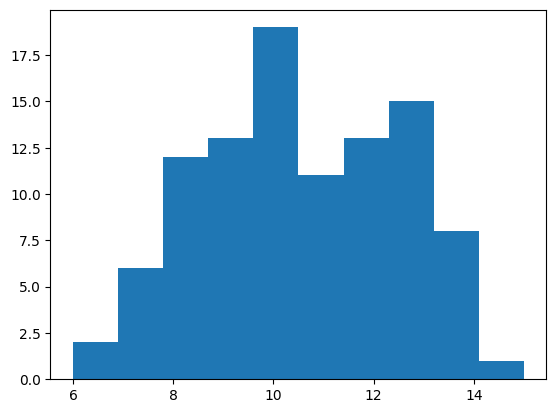

In [7]:
'''
## EXERCISE 6 ##
Now that you have the code to simulate the season wrapped in a function, try running it a bunch of
times (say, 1000) to estimate the probability that Inter Miami makes the playoffs (i.e. finishes
9th or higher in the Eastern Conference).
'''
